# Levitt (1997) を再現してみる

Levitt (1997) は操作変数法を用いて警察の増強が犯罪件数に与える効果を推定した。
市長選のタイミングに警官が増強されることに着目し、その年の市長選の有無を操作変数に利用した。

[Levitt, S. D. (1997). Using electoral cycles in police hiring to estimate the effect of policeon crime.](http://home.cerge-ei.cz/gebicka/files/IV_Simultaneity.pdf)


## データの入手元

McCraryが再現研究を行ってデータも公開している

[Replication of Steven Levitt (AER, 1997), Justin McCrary 9/01](https://eml.berkeley.edu/replications/mccrary/index.html)

- `mccrary/data` は再現研究のほうのデータ
- `mccrary/originallevittfiles` はlevittがMcCraryに送ったデータっぽい


In [1]:
!cd "/workdir"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
df = pd.read_stata("mccrary/originallevittfiles/crime.dta")
df

,name,city,statenam,state,censdist,year,sworn,civil,elecyear,governor,...,a10_14,a15_19,a20_24,a25_29,citybla,cityfemh,sta_educ,sta_welf,price,termlim
0,albuquerque,1,,31,85.0,69,328.0,127.0,1,0.0,...,0.120523,0.101880,0.087395,0.068698,NaN,NaN,NaN,NaN,NaN,0.0
1,albuquerque,1,nm,31,85.0,70,370.0,124.0,0,1.0,...,0.115725,0.101487,0.089538,0.072414,2.20,12.30,829.896973,157.216507,0.388,0.0
2,albuquerque,1,nm,31,85.0,71,377.0,197.0,0,0.0,...,0.111225,0.101117,0.091548,0.075900,2.23,12.19,834.567871,172.839508,0.405,1.0
3,albuquerque,1,nm,31,85.0,72,389.0,155.0,0,0.0,...,0.106995,0.100770,0.093436,0.079176,2.26,12.08,846.889954,179.425827,0.418,1.0
4,albuquerque,1,nm,31,85.0,73,447.0,137.0,1,0.0,...,0.103013,0.100443,0.095215,0.082261,2.29,11.97,828.828857,173.423431,0.444,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,corpuschri,85,tx,43,74.0,88,350.0,128.0,0,0.0,...,0.086284,0.084445,0.073147,0.084052,4.86,13.12,832.453735,151.898453,1.183,0.0
1412,corpuschri,85,tx,43,74.0,89,355.0,139.0,1,0.0,...,0.085946,0.082849,0.070815,0.083415,4.83,13.46,847.580627,159.677414,1.240,0.0
1413,corpuschri,85,tx,43,74.0,90,370.0,146.0,0,1.0,...,0.085612,0.081273,0.068513,0.082786,4.80,13.80,873.756775,193.573074,1.307,0.0
1414,corpuschri,85,tx,43,NaN,91,380.0,144.0,1,0.0,...,0.085283,0.079718,0.066240,0.082166,4.77,14.14,847.232483,234.686340,NaN,0.0


### データ

1970 ~ 1992年のアメリカの59都市における警察官数や犯罪数などのデータ

- sworn: # of sworn police officers employed by city as of November 1（正規の警察官）
- civil: # of civilian police employees by city as of November 1
  - sworn + civil = total police officer

## 前処理

一部の変数はcityごとに変化率にする

```python
# test code
col = "sworn"
x = df.query("name == 'chicago'")[col]
y1 = np.log(x) - np.log(x.shift())  # stataのコードを真似るとこんなかんじ
y2 = np.log(x).diff() # pandasっぽい書き方
assert (y1.dropna() == y2.dropna()).all()
```

MEMO: 事前にソートしていれば

```python
for col in ["sworn", *violent_crimes, *property_crimes, "sta_educ", "sta_welf"]:
    for name, d in df.groupby("name"):
        x = d.sort_values("year")[col]
        df.loc[d.index, f"d_{col}"] = np.log(x).diff()
```

と

```python
for col in ["sworn", *violent_crimes, *property_crimes, "sta_educ", "sta_welf"]:
    df[f"d_{col}"] = np.log(df[col]).diff()
```

は同値になる

In [4]:
# firststa.doを参考に10万人あたりの数にする
for col in ["sworn", "civil", "murder", "rape", "assault", "robbery", "sta_educ", "sta_welf"]:
    df[col] = df[col] / df["citypop"] * 100_000
    
# 都市ごとに年について差分をとって変化率にするために、都市名と年でソートする
df = df.sort_values(["name", "year"])

# Δln (変化率) にする
violent_crimes = ["murder", "rape", "robbery", "assault"]
property_crimes = ["burglary", "larceny", "auto"]
for col in ["sworn", *violent_crimes, *property_crimes, "sta_educ", "sta_welf"]:
    df[f"d_{col}"] = np.log(df[col]).diff()
# 割合系のやつも差分をとって変化率にする
df["a15_24"] = df["a15_19"] + df["a20_24"]
percent_covariates = ["unemp", "a15_24", "citybla", "cityfemh"]
for col in percent_covariates:
    df[f"d_{col}"] = df[col].diff()

# citysize
df["citysize"] = 0
citypop = df["citypop"]
df.loc[citypop<250000, "citysize"] = 1
df.loc[(citypop<500000) & (citypop>=250000), "citysize"] = 2
df.loc[(citypop<1000000) & (citypop>=500000), "citysize"] = 3
df.loc[(citypop>=1000000), "citysize"] = 5

# 前年の警察官の変化率（1年遅れで効果がでる可能性を考慮）
df["d_sworn_2"] = df["d_sworn"].shift(1)

In [5]:
df

,name,city,statenam,state,censdist,year,sworn,civil,elecyear,governor,...,d_larceny,d_auto,d_sta_educ,d_sta_welf,a15_24,d_unemp,d_a15_24,d_citybla,d_cityfemh,citysize
1344,akron,82,,35,31.0,69,NaN,NaN,0,0.0,...,NaN,NaN,NaN,NaN,0.188594,NaN,NaN,NaN,NaN,0
1345,akron,82,oh,35,31.0,70,174.545455,9.090909,0,1.0,...,NaN,NaN,NaN,NaN,0.189114,0.02550,0.000520,NaN,NaN,2
1346,akron,82,oh,35,31.0,71,193.226608,9.236453,1,0.0,...,-0.085905,-0.022014,0.058891,0.200785,0.189637,0.01217,0.000523,0.469999,0.080000,2
1347,akron,82,oh,35,31.0,72,182.608696,9.057971,0,0.0,...,-0.120404,-0.113231,0.035561,0.149564,0.190163,-0.00925,0.000526,0.470001,0.080000,2
1348,akron,82,oh,35,31.0,73,175.171915,9.048136,0,0.0,...,0.155387,-0.688174,0.042420,0.079649,0.190691,-0.01284,0.000529,0.469999,0.080000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,washington,50,dc,51,NaN,88,632.258065,115.806446,0,0.0,...,0.135303,0.315519,0.027459,0.059907,0.155112,-0.01300,-0.003363,-0.450005,0.019999,3
1124,washington,50,dc,51,NaN,89,657.947020,122.847687,0,0.0,...,0.018408,-0.040421,0.073613,0.031584,0.151866,0.00000,-0.003246,-0.449997,0.020000,3
1125,washington,50,dc,51,NaN,90,781.018290,128.686766,1,0.0,...,0.040820,-0.022197,-0.019776,0.004002,0.148731,0.01600,-0.003135,-0.449997,0.020000,3
1126,washington,50,dc,51,NaN,91,752.842809,108.026760,0,0.0,...,-0.040614,0.002832,-0.256343,-0.297501,0.145702,0.01100,-0.003029,-0.450005,0.020000,3


## plot

<AxesSubplot:xlabel='sworn', ylabel='murder'>

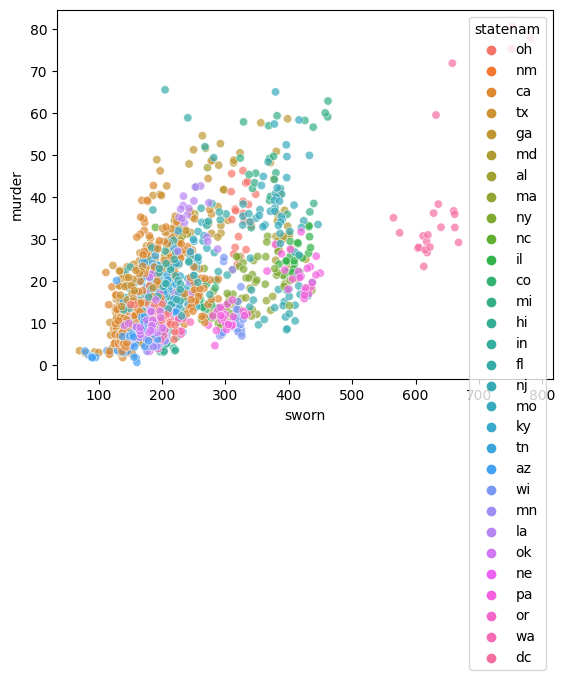

In [7]:
sns.scatterplot(data=df, x="sworn", y="murder", hue="statenam", alpha=.7)

<AxesSubplot:xlabel='year', ylabel='sworn'>

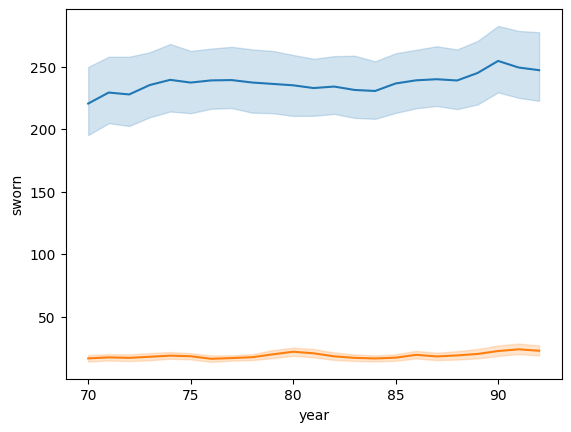

In [8]:
sns.lineplot(data=df, x="year", y="sworn")
sns.lineplot(data=df, x="year", y="murder")

## Election Cycle

- 経済が順調なとき、治安は世論調査で最も重要な論点とされることが多い
- 市長選において、現職者は犯罪抑制に取り組んでいることを示すインセンティブが生じる
  - 市長は警察を増強する権限がある
  - アメリカでは連邦、州、市などの自治体レベルでそれぞれ警察組織があり、Policeは市警察。連邦警察はFBIとかで麻薬など特定分野を専門とする
- 市長は経済問題に対して効果的に介入する権限を持たない
- 州政府は市政府へ予算を与えることができ、間接的な介入がありうる

In [9]:
# Δln Police と選挙（Nは一致、平均値がやや異なる）
pd.DataFrame({
    "Guvernatorial election": df.query("governor == 1")["d_sworn"],
    "Mayoral election": df.query("elecyear == 1")["d_sworn"],
    "No election": df.query("(governor == 0) & (elecyear == 0)")["d_sworn"],
}).describe().round(3)

,Guvernatorial election,Mayoral election,No election
count,302.000,391.000,621.000
mean,0.018,0.014,-0.003
std,0.063,0.064,0.057
min,-0.267,-0.286,-0.340
25%,-0.018,-0.021,-0.030
50%,0.010,0.008,-0.003
75%,0.047,0.038,0.028
max,0.338,0.366,0.290


## 共変量

選挙が、福祉や教育への支出を通じて、犯罪に影響を与えるパスが考えられる
そのパスを閉じるために共変量に追加する（p.279, Section Ⅲ冒頭）

## Section Ⅱ

### 警察官の数のモデル（First stage：Z → X）

$$
\Delta \ln P_{it} = \Theta_1 M_{it} + \Theta_2 G_{it}
+ \boldsymbol{X}_{it} \delta
+ \gamma_t + \lambda_i + \nu_{it}
$$

- $P_{it}$：都市$i$の$t$年の人口あたりの警察官の数の変化率
- $M_{it}$：市長選（mayoral election）の有無
- $G_{it}$：州知事選（gubernatorial election）の有無
- $\boldsymbol{X}_{it}$：共変量（デモグラフィック、州と地方の歳出、都市のサイズのindicator、地域ダミーと年ダミー）
- $\gamma_t$：説明はないが年の固定効果っぽい
- $\lambda_i$：説明はないが都市の固定効果っぽい


論文だとTable 2の(1) ~ (3)

コードだと`firststa.do`の240行あたり


### 犯罪件数のモデル（reduced form：Z→Y）

説明変数は一緒

論文だとTable 2の(4), (5)

Reduced formだとこの表記

$$
\Delta \ln C_{ijt} = \Psi_1 M_{it} + \Psi_2 G_{it}
+ \boldsymbol{X}_{it} \kappa_j
+ \gamma_{tj} + \lambda_i + \nu_{ijt}
$$

- $C_{ijt}$：都市$i$の$t$年の人口あたりの犯罪$j$の数の年間変化率
- $M_{it}$：市長選（mayoral election）の有無
- $G_{it}$：州知事選（gubernatorial election）の有無
- $\boldsymbol{X}_{it}$：共変量（デモグラフィック、州と地方の歳出、都市のサイズのindicator、地域ダミーと年ダミー）
- $\gamma_t$：説明はないが年の固定効果っぽい
- $\lambda_i$：説明はないが都市の固定効果っぽい

In [13]:
from stargazer.stargazer import Stargazer
import statsmodels.api as sm

# first stage
Stargazer([
    sm.OLS.from_formula(formula="d_sworn ~ elecyear + governor + d_sta_educ + d_sta_welf + d_unemp + d_a15_24 + d_citybla + d_cityfemh + citysize + year + name",
                        data=df.assign(year = lambda self: self.year.astype('category'))).fit(),
    sm.OLS.from_formula(formula="d_murder ~ elecyear + governor + d_sta_educ + d_sta_welf + d_unemp + d_a15_24 + d_citybla + d_cityfemh + citysize + year + name",
                        data=df.assign(year = lambda self: self.year.astype('category'))).fit(),
    sm.OLS.from_formula(formula="d_rape ~ elecyear + governor + d_sta_educ + d_sta_welf + d_unemp + d_a15_24 + d_citybla + d_cityfemh + citysize + year + name",
                        data=df.assign(year = lambda self: self.year.astype('category'))).fit(),
])

## 2SLS


$$
\Delta \ln C_{ijt} = 
  \beta_{1j} \Delta \ln P_{it}
+ \beta_{2j} \Delta \ln P_{it-1}
+ \boldsymbol{X}_{it} \eta_j
+ \gamma_{tj}
+ \lambda_i
+ \varepsilon_{ijt}
$$


In [11]:
df.columns

Index(['name', 'city', 'statenam', 'state', 'censdist', 'year', 'sworn',
       'civil', 'elecyear', 'governor', 'murder', 'rape', 'robbery', 'assault',
       'burglary', 'larceny', 'auto', 'rincpc', 'econgrow', 'unemp', 'citypop',
       'term2', 'term3', 'term4', 'a0_5', 'a5_9', 'a10_14', 'a15_19', 'a20_24',
       'a25_29', 'citybla', 'cityfemh', 'sta_educ', 'sta_welf', 'price',
       'termlim', 'd_sworn', 'd_murder', 'd_rape', 'd_robbery', 'd_assault',
       'd_burglary', 'd_larceny', 'd_auto', 'd_sta_educ', 'd_sta_welf',
       'a15_24', 'd_unemp', 'd_a15_24', 'd_citybla', 'd_cityfemh', 'citysize',
       'd_sworn_2'],
      dtype='object')

In [18]:
from linearmodels.iv import IV2SLS
formula = """
    d_rape ~ d_sta_educ + d_sta_welf + d_unemp + d_a15_24 + d_citybla + d_cityfemh + citysize + year + name
    + [d_sworn + d_sworn_2 ~ elecyear + governor]
"""
use_cols = formula.replace("~", " ").replace("[", " ").replace("]", " ").replace("+", " ").split()
model = IV2SLS.from_formula(
    formula=formula,
    data=df[use_cols].dropna().astype({"year": "category"})
).fit()

print(
    model.params["d_sworn"],
    model.params["d_sworn_2"]
)
model

-0.3084087873604915 2.6141228944928514


IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 d_rape   R-squared:                     -0.7820
Estimator:                    IV-2SLS   Adj. R-squared:                -0.9230
No. Observations:                1187   F-statistic:                    164.81
Date:                Wed, Aug 02 2023   P-value (F-stat)                0.0000
Time:                        22:22:39   Distribution:                 chi2(88)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                   
========================================================================================
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
d_sta_educ               0.7083     0.4254     1.6651     0.0959     -0.1254      1.5420
d_sta_welf              -0.0175     0.0464    -0.3759     0.7070     -0.1084      0.0735
d_unemp                 -1.0435     1.2146    -0.8591     0.3903     -3.4242      1.3371
d_a15_24                -14.260     19.623    -0.7267     0.4674     -52.720      24.200
d_citybla                0.0029     0.0679     0.0425     0.9661     -0.1302      0.1360
d_cityfemh              -0.0835     0.1285    -0.6502     0.5156     -0.3353      0.1683
citysize                 0.0133     0.0371     0.3578     0.7205     -0.0595      0.0861
year[T.72]              -0.0423     0.1798    -0.2351     0.8141     -0.3948      0.3102
year[T.73]               0.0696     0.1525     0.4568     0.6478     -0.2292      0.3685
year[T.74]               0.0784     0.1598     0.4907     0.6237     -0.2348      0.3916
year[T.75]              -0.0581     0.1081    -0.5373     0.5911     -0.2699      0.1537
year[T.76]              -0.0584     0.0939    -0.6223     0.5338     -0.2425      0.1256
year[T.77]               0.0980     0.0842     1.1640     0.2444     -0.0670      0.2630
year[T.78]               0.0738     0.0771     0.9572     0.3385     -0.0773      0.2249
year[T.79]               0.1727     0.0647     2.6696     0.0076      0.0459      0.2995
year[T.80]               0.1229     0.0687     1.7886     0.0737     -0.0118      0.2576
year[T.81]              -0.0320     0.1005    -0.3188     0.7499     -0.2290      0.1649
year[T.82]              -0.0654     0.1005    -0.6511     0.5150     -0.2623      0.1315
year[T.83]              -0.0703     0.1105    -0.6367     0.5243     -0.2869      0.1462
year[T.84]               0.0012     0.0984     0.0122     0.9903     -0.1918      0.1942
year[T.85]              -0.0223     0.1177    -0.1895     0.8497     -0.2529      0.2083
year[T.86]              -0.0996     0.1761    -0.5652     0.5719     -0.4448      0.2457
year[T.87]              -0.1802     0.1474    -1.2220     0.2217     -0.4691      0.1088
year[T.88]              -0.0778     0.1028    -0.7565     0.4493     -0.2794      0.1238
year[T.89]              -0.0923     0.1251    -0.7372     0.4610     -0.3375      0.1530
year[T.90]              -0.0072     0.1909    -0.0375     0.9701     -0.3813      0.3670
year[T.91]              -0.1127     0.1545    -0.7292     0.4659     -0.4155      0.1902
year[T.92]              -0.0360     0.0773    -0.4660     0.6412     -0.1875      0.1154
name[T.albuquerque]     -0.0463     0.1126    -0.4109     0.6811     -0.2670      0.1745
name[T.anaheim]          0.0122     0.0892     0.1369     0.8911     -0.1625      0.1870
name[T.arlington]       -0.0042     0.1689    -0.0247     0.9803     -0.3351      0.3268
name[T.atlanta]         -0.0682     0.1719    -0.3966     0.6916     -0.4052      0.2688
name[T.austin]          -0.0340     0.1317    -0.2580     0.7964     -0.2920      0.2241
name[T.baltimore]     